# Time Series Generation with Class Label Guidance

In this tutorial, we will go through how to generate time series with class labels. 

## Problem setting
Given a time series class label (e.g. patient status), $\mathbf{c} \in \mathbb{R}^{C}$, we are interested in the conditional distribution, i.e. $p(\mathbf{x}_{\text{target}} \mid \mathbf{c})$. From this distribution, we can sample possible conditional time series $\hat{\mathbf{x}}_{\text{target}} \in \mathbb{R}^{T \times D}$ that are aligned with the given class label.

## Implementation
### 1. import modules
Print all models that suport class label guidance

In [1]:
import torch
from gents.dataset import Spiral2D
from gents.model import TimeVQVAE
from lightning import Trainer
from gents.evaluation import tsne_visual
from gents.evaluation import context_fid

import gents.model

class_model = []
for name in gents.model.__all__:
    model_cls = getattr(gents.model, name)
    if 'class' in model_cls.ALLOW_CONDITION:
        class_model.append(name)
class_model

/home/wcx/anaconda3/envs/gents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


['VanillaVAE', 'TimeVQVAE', 'VanillaGAN', 'RCGAN', 'VanillaDDPM', 'VanillaMAF']

### 2. setup datamodule and model
Here, `Spiral2D` data has two class labels, i.e. clock-wise and counter clock-wise. We set $T=32$ for illustration. Note that `condition='class'` and `class_num=2` is also required for datamodule and model for setup.

In [2]:
dm = Spiral2D(
    seq_len=32,
    batch_size=64,
    num_samples=3000,
    data_dir="../data",
    condition="class",
)
model = TimeVQVAE(
    seq_len=dm.seq_len,
    seq_dim=dm.seq_dim,
    condition="class",
    class_num=2,
)

### 3. setup training
Utilizing `lightning`/`pytorch-lightning`, one can easily set:
- GPU devices
- Training epochs/steps
- Callbacks
- etc..

In [3]:
trainer = Trainer(max_steps=3000, devices=[0], enable_progress_bar=False)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | encoder_l     | VQVAEEncoder             | 20.8 K | train
1 | encoder_h     | VQVAEEncoder             | 20.0 K | train
2 | vq_model_l    | VectorQuantize           | 2.2 K  | train
3 | vq_model_h    | VectorQuantize           | 2.2 K  | train
4 | decoder_l     | VQVAEDecoder             | 3.8 K  | train
5 | decoder_h     | VQVAEDec

### 4. Evaluation
Qualitative evaluation: TSNE visualization

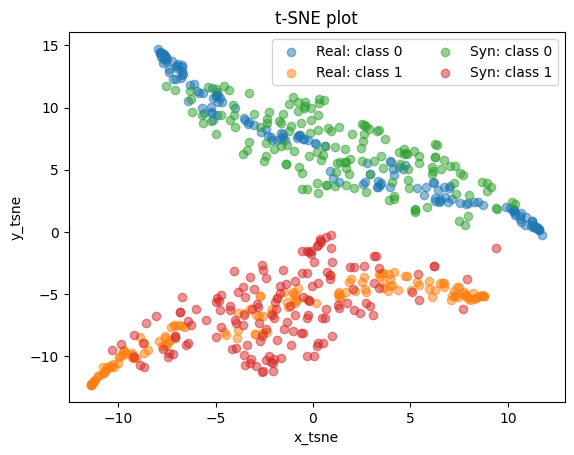

In [4]:
# testing
dm.setup("test")
real_data = torch.cat([batch["seq"] for batch in dm.test_dataloader()])
cond_data = torch.cat([batch["c"] for batch in dm.test_dataloader()])

# generate samples with the same number as real data
# and same condition
gen_data = model.sample(n_sample=len(real_data), condition=cond_data)  # [N, 64, 2]
tsne_visual(real_data, gen_data, cond_data)


Quantitative evaluation: context-fid

In [6]:
context_fid(
    real_data.numpy(), gen_data.numpy(), device="cuda:0", train_data=dm.train_ds.data.numpy(), 
)

train a new ts2vec model


np.float64(0.8106987850150742)